In [44]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import math
import ipynbname
from pathlib import Path
from tqdm.notebook import tqdm
RNG = np.random.default_rng(2025)
size = 10

## Which estimator is more robust?

### Example: estimating $\mu$
Let's try sample mean and sample median in a clean data set.

In [45]:
population_mean = 0
obs = RNG.normal(population_mean, 1, size = 10)
mean = np.mean(obs)
median = np.median(obs)
print("Observations:", np.round(obs, 3))
print("Mean:", np.round(mean, 3))
print("Median:", np.round(median, 3))

Observations: [-2.221  0.026 -0.539 -1.129 -2.442  0.765 -0.76   0.267  0.702  0.292]
Mean: -0.504
Median: -0.256


What if now we contaminate the data with an extreme value -100?

In [46]:
obs_c = copy.deepcopy(obs)
obs_c[0] = -100
mean_c = np.mean(obs_c)
median_c = np.median(obs_c)
print("Contaminated observations:", np.round(obs_c, 3))
print("Contaminated mean:", np.round(mean_c, 3))
print("Contaminated median:", np.round(median_c, 3))

Contaminated observations: [-1.000e+02  2.600e-02 -5.390e-01 -1.129e+00 -2.442e+00  7.650e-01
 -7.600e-01  2.670e-01  7.020e-01  2.920e-01]
Contaminated mean: -10.282
Contaminated median: -0.256


What is the empirical influence of this data point in this specific data set?

In [47]:
EIF_mean = mean - mean_c
EIF_median = median - median_c
print("Empirical influence in observed mean:", EIF_mean)
print("Empirical influence in median:", EIF_median)

Empirical influence in observed mean: 9.77787461242546
Empirical influence in median: 0.0


What is the empirical infleunce of this data point across 1000 data sets?

In [48]:
n_replication = 1000
obs = RNG.normal(population_mean, 1, size = (n_replication, 10))
obs_c = copy.deepcopy(obs)
obs_c[:,0] = -100
mean = np.mean(obs, axis = 1)
median = np.median(obs, axis = 1)
mean_c = np.mean(obs_c, axis = 1)
median_c = np.median(obs_c, axis = 1)

EIF_mean = mean - mean_c
EIF_median = median - median_c
print("Empirical influence in observed mean across", n_replication, "replications:", np.round(np.mean(EIF_mean),3))
print("Empirical influence in observed median across", n_replication, "replications:", np.round(np.mean(EIF_median),3))

Empirical influence in observed mean across 1000 replications: 10.0
Empirical influence in observed median across 1000 replications: 0.14


A nice curve to have?

In [49]:
def compute_eif(xinfl, n_replication):
    nrx=len(xinfl)
    infl_mean = np.zeros(shape=(nrx, 1))
    infl_median = np.zeros(shape=(nrx, 1))
    
    for j in tqdm(range(nrx), desc="Progress", leave=False):
        obs = RNG.normal(population_mean, 1, size = (n_replication, 10))
        obs_c = copy.deepcopy(obs)
        obs_c[:,0] = xinfl[j]

        mean = np.mean(obs, axis = 1)
        median = np.median(obs, axis = 1)
        mean_c = np.mean(obs_c, axis = 1)
        median_c = np.median(obs_c, axis = 1)

        infl_mean[j] = np.mean(mean_c - mean)
        infl_median[j] = np.mean(median_c - median_c)
        del obs, obs_c
    
    return infl_mean, infl_median

In [50]:
xinfl = np.arange(-100, 101)
%time infl_mean, infl_median = compute_eif(xinfl=xinfl,n_replication=1000)

Progress:   0%|          | 0/201 [00:00<?, ?it/s]

CPU times: total: 109 ms
Wall time: 109 ms


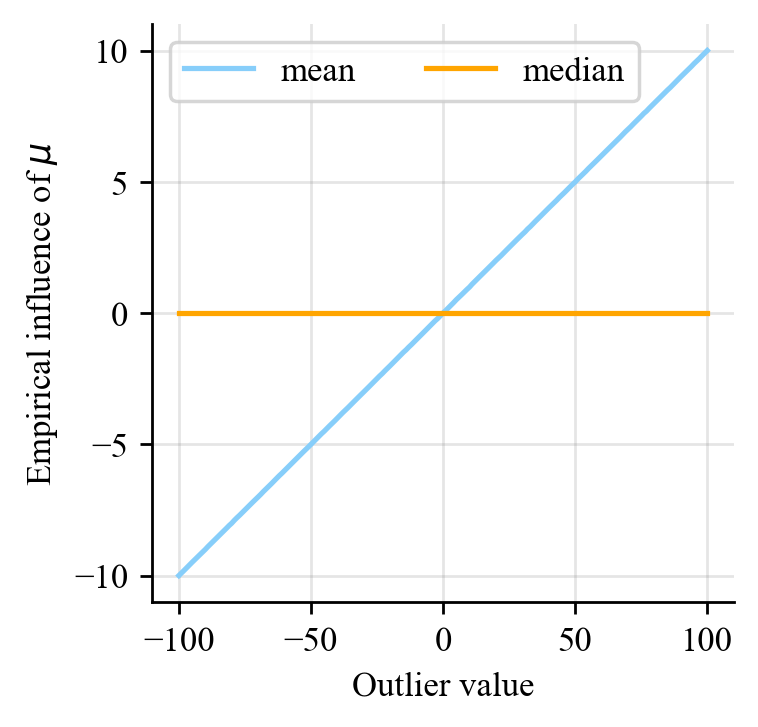

In [51]:
#Plot the EIF
plt.figure(figsize=(3, 3),dpi=250)
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(xinfl,infl_mean,color='lightskyblue',linestyle='-',label='mean')
plt.plot(xinfl,infl_median,color='orange',linestyle='-',label='median')

plt.xlabel('Outlier value',size=size)
plt.ylabel('Empirical influence of ' r'$\mu$',size=size)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


# Set grey grid
plt.grid(color='grey', linestyle='-',alpha=0.2)

plt.legend(ncol=2, loc="upper left", frameon=True, fontsize=size)
plt.tick_params(axis='x', labelsize=size)
plt.tick_params(axis='y', labelsize=size)


In [52]:
#Define BP
def compute_bp(ninfl, n_replication):
    nrx=len(ninfl)
    bp_mean = np.zeros(shape=(nrx, 1))
    bp_median = np.zeros(shape=(nrx, 1))
    
    for j in tqdm(range(nrx), desc="Progress", leave=False):
        obs = RNG.normal(population_mean, 1, size = (n_replication, 10))
        obs_c = copy.deepcopy(obs)
        obs_c[:,0:j] = -100
        bp_mean[j] = np.mean(np.mean(obs_c, axis=1))
        bp_median[j] = np.mean(np.median(obs_c, axis=1))
    
    return bp_mean, bp_median

In [53]:
%time bp_mean, bp_median = compute_bp(ninfl = np.arange(0,11), n_replication = 1000)

Progress:   0%|          | 0/11 [00:00<?, ?it/s]

CPU times: total: 0 ns
Wall time: 7.37 ms


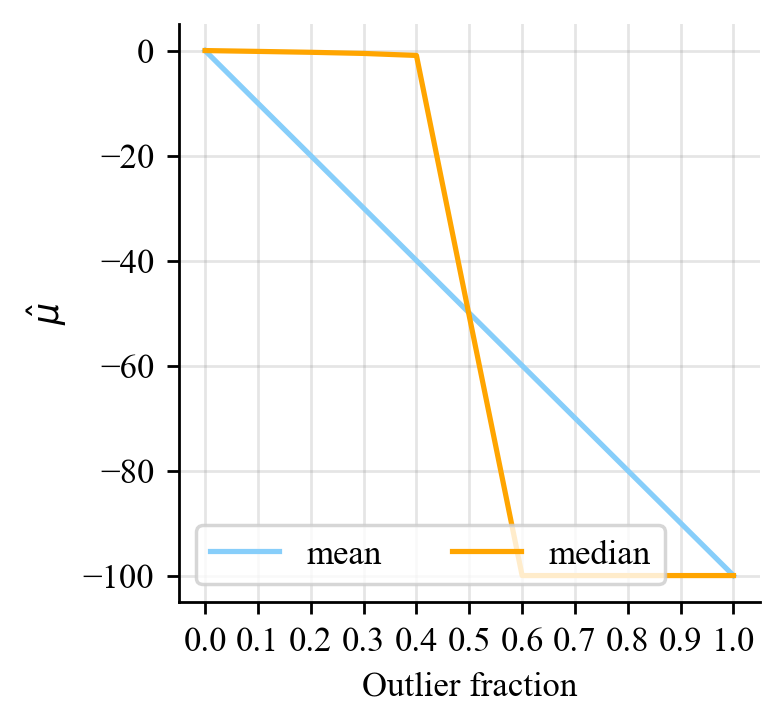

In [54]:
#Plot BP
plt.figure(figsize=(3,3), dpi=250)
plt.plot(np.arange(0,1.1,0.1),bp_mean, color ='lightskyblue',label='mean')
plt.plot(np.arange(0,1.1,0.1),bp_median, color ='orange',label='median')

plt.xlabel('Outlier fraction',size=size)
plt.ylabel(r'$\hat{\mu}$',size=size)
plt.xticks(np.arange(0, 1.1, 0.1))


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.grid(color='grey', linestyle='-',alpha=0.2)

plt.legend(ncol=2, loc="lower left", frameon=True, fontsize=size)
plt.tick_params(axis='x', labelsize=size)
plt.tick_params(axis='y', labelsize=size)

## A robust maximum likelihood estimator
and you can play around with the ``` k = ? ``` to see k's influence on residuals' weights.

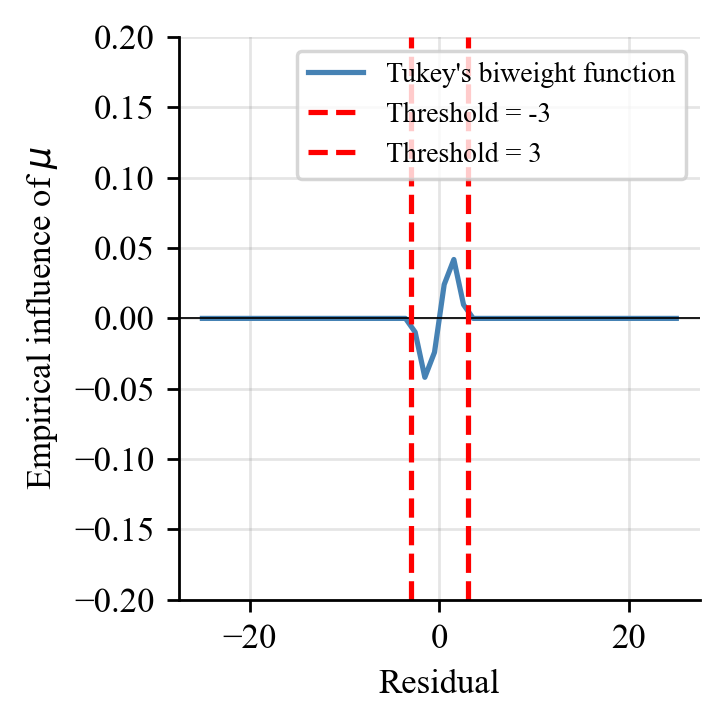

In [58]:
def tukey_biweight_influence_function(x, k):
    influence = np.zeros_like(x)
    mask = np.abs(x) <= k
    influence[mask] = (x[mask] * (1 - (x[mask] / k)**2)**2)/20
    return influence

# Set the tuning constant c
k = 3  # Typical choice for robust estimation
x_vals = np.linspace(-25, 25, 50)
# Compute the influence function values
influence_vals = tukey_biweight_influence_function(x_vals, k)

# Plotting the Tukey biweight influence function
plt.figure(figsize=(3, 3),dpi=250)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


# Set grey grid
plt.grid(color='grey', linestyle='-',alpha=0.2)
plt.ylim(-0.2,0.2)
plt.plot(x_vals, influence_vals, label=r"Tukey's biweight function", color='steelblue')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(-k, color='red', linestyle='--', label=f'Threshold = -{k}')
plt.axvline(k, color='red', linestyle='--', label=f'Threshold = {k}')
plt.xlabel('Residual', fontsize=size)
plt.ylabel('Empirical influence of ' r'$\mu$''', fontsize=size)
plt.legend(fontsize=size-2)
plt.tight_layout()


## student t distribution

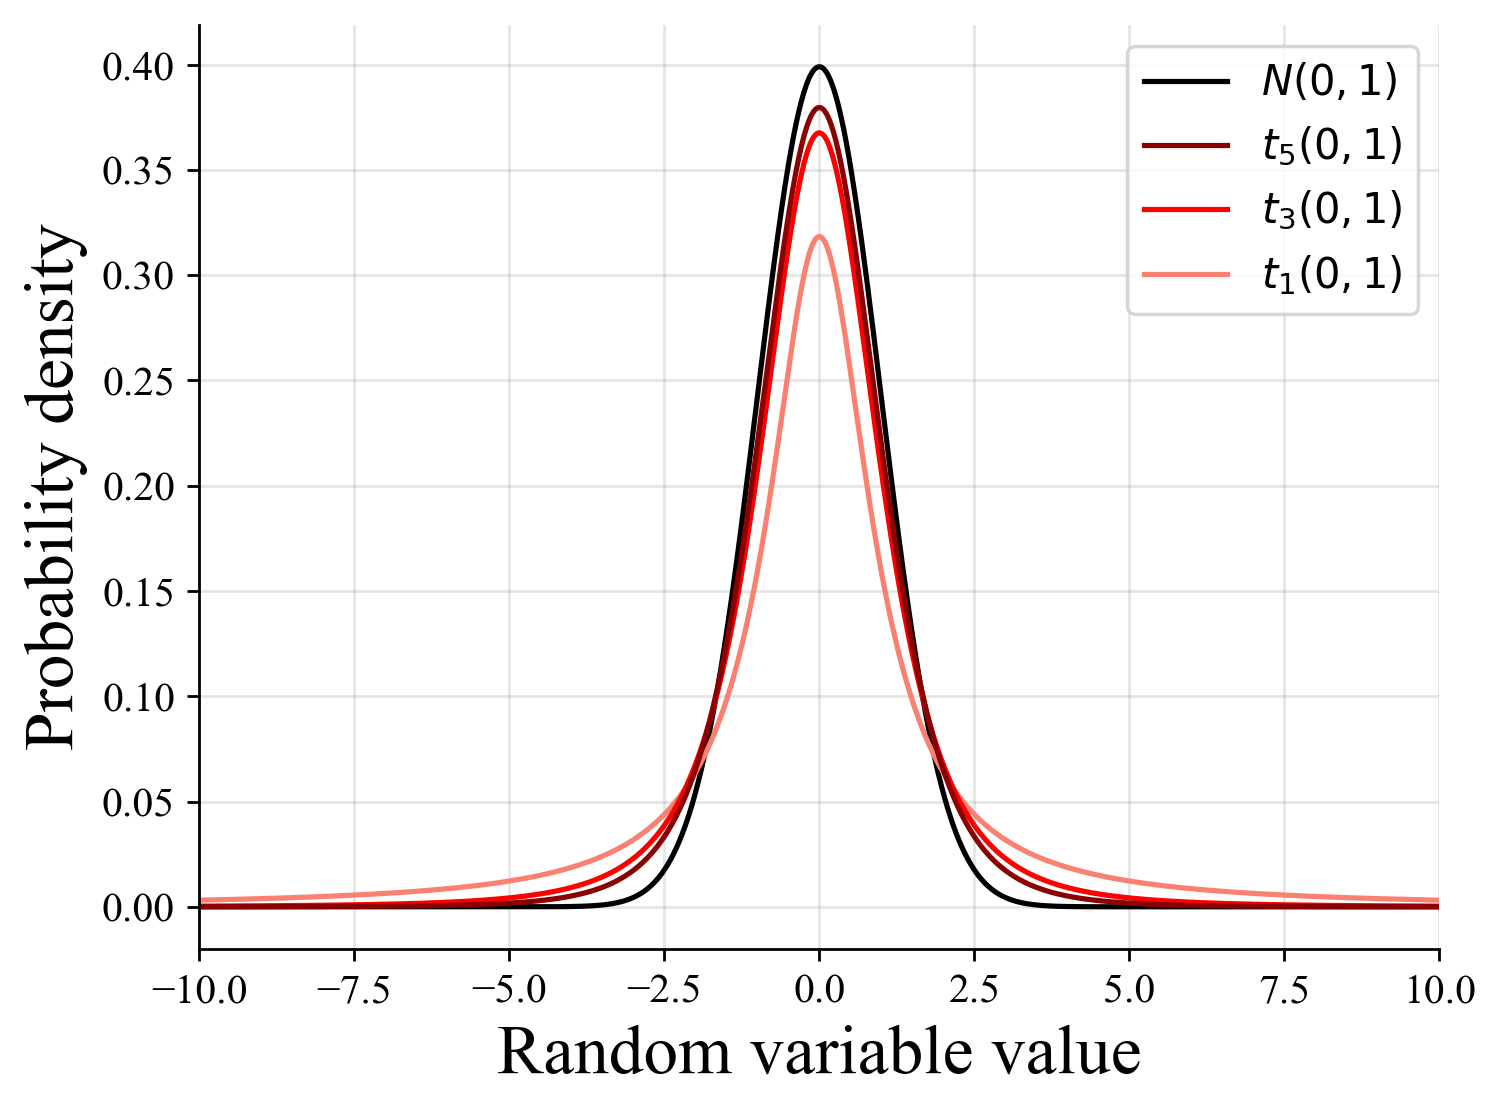

In [43]:
from scipy.stats import norm, t
x = np.linspace(-10, 10, 1000)
normal = norm.pdf(x,loc=0,scale=1)
t_df1 = t.pdf(x,1)
t_df3 = t.pdf(x,3)
t_df5 = t.pdf(x,5)

plt.figure(dpi=250)
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(x, normal, color = 'black',label='Standard normal distribution')
plt.plot(x, t_df1, color = 'salmon', label='Standard t distribution, df=1')
plt.plot(x, t_df3, color = 'red', label='Standard t distribution, df=3')
plt.plot(x, t_df5, color = 'darkred', label='Standard t distribution, df=5')
plt.xlim(x.min(),x.max())
plt.ylabel('Probability density',size=20)
plt.xlabel('Random variable value',size=20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


# Set grey grid
plt.grid(color='grey', linestyle='-',alpha=0.2)


plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.legend(loc='upper right', handles=[plt.Line2D([], [], color='black', label=r'$N(0,1)$'),
                                plt.Line2D([], [], color='darkred', label=r'$t_5(0,1)$'),
                                plt.Line2D([], [], color='red', label=r'$t_3(0,1)$'),
                                plt.Line2D([], [], color='salmon', label=r'$t_1(0,1)$')],fontsize=12)